In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp
from numpy.linalg import inv
np.random.seed(8008)

from scipy.integrate import odeint
from IPython.display import Latex
from tqdm import trange

In [3]:
#Fix parameters and initial conditions
N = 4000
dt = 0.02
iterate = 50
t0 = 0
t1 = N*dt
init=[1,1,1]

In [4]:
#Lorenz system
def get_lorenz_vals(dt, ic):
    def lorenz1(xyz, t, s=10, r=28, b=8/3):
        x,y,z = xyz
        dx = s*(y - x)
        dy = r*x - y - x*z
        dz = x*y - b*z
        return np.array([dx,dy,dz])
    
    from scipy.integrate import odeint
    sol = odeint(lorenz1, ic, dt)
    xs,ys,zs = sol.T

    return sol.T

In [5]:
#Implement the Algorithm withoud noise
def find_approximation(system: callable, t0: float, t1: float,
                       N=N, D_r=300, w=0.005, b=4, beta=4e-5): 
    ic = init #random initial condition from 0 to 5 every time
    U: np.ndarray = system(np.linspace(t0, t1, N+1), ic)
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = np.tanh(W_in @ U_i + b_in)  #(1/np.sqrt(D_r))*
    W_LR = U_o @ Phi.T @ inv(Phi @ Phi.T + beta* np.identity(D_r))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in) #(1/np.sqrt(D_r))*
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    #U_pred = np.atleast_2d(U_hat[:, -1]).T # Further approximation starting from u_(n+1), will not be used in this experiment
    #for _ in range(N):
        #u_n = U_pred[:, -1]
        #phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        #u_np1 = W_LR @ phi
        #U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat, U_pred
    return U, U_hat#, U_pred

In [6]:
def find_tf(system, N, D_r, t0 = t0, t1 = t1):
    U, U_hat = find_approximation(system, t0, t1, N=N, D_r=D_r)
    error = 0
    tf = 0
    n=0
    while error <= 0.05:
        error = (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        tf += dt
        n += 1
    return tf

find_tf(get_lorenz_vals, N, 1000)

6.3999999999999515

In [7]:
# For the case with noise
def find_approx_noise(system: callable, t0: float, t1: float,
                       N=N, D_r=300, w=0.005, b=4, beta=4e-5):
    ic = init
    U: np.ndarray = system(np.linspace(t0, t1, N+1),ic)
    U = U + 0.2*np.random.normal(0, 1, np.shape(U)) # Noise in uniform distribution (-1,1) * 0.2
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    #U_pred = np.atleast_2d(U_hat[:, -1]).T
    #for _ in range(N):
        #u_n = U_pred[:, -1]
        #phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        #u_np1 = W_LR @ phi
        #U_pred = np.concatenate((U_pred, u_np1), axis=1)

    return U, U_hat#, U_pred

def find_tfnoise(system, N, D_r, t0 = t0, t1 = t1):
    U, U_hat = find_approx_noise(system, t0, t1, N=N, D_r=D_r)
    error = 0
    tf = 0
    n=0
    while error <= 0.05:
        error = (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        tf += dt
        n += 1
    return tf
find_tfnoise(get_lorenz_vals, N, 7500)

0.04

100%|██████████| 50/50 [37:53<00:00, 45.47s/it]


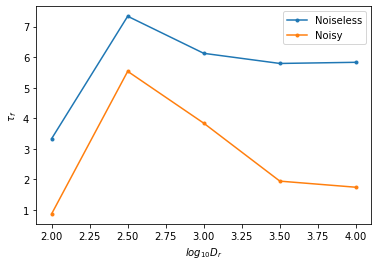

In [8]:
logdr = np.arange(2,4.5,0.5)
dr = 10**(logdr)

tf = np.zeros(len(dr))
tfn = np.zeros(len(dr))

for i in trange(iterate):
    tf0 = []
    tfn0 = []
    for d in dr:   
        tf0.append(find_tf(get_lorenz_vals, N, int(round(d))))
        tfn0.append(find_tfnoise(get_lorenz_vals, N, int(round(d))))
    tf = tf + np.array(tf0)
    tfn = tfn + np.array(tfn0)
    
tf = tf/iterate
tfn = tfn/iterate

plt.plot(logdr, tf, marker='.', label='Noiseless')
plt.plot(logdr, tfn, marker='.', label='Noisy')
plt.xlabel('$log_{10}D_r$')
plt.ylabel('$τ_f$')
plt.legend()
plt.savefig("D_r_zeronoise.jpg", dpi=150, bbox_inches='tight')

In [ ]:
d = round(10**4.75)
tf0 = 0
for i in range(iterate):
    tf0 += find_tf(get_lorenz_vals, N, d)
print(tf0)

In [ ]:
from IPython.display import Latex
Latex(rf'$D_r$')
Latex(rf'$τ_f$')

In [ ]:
dr


In [ ]:
#N with coefficient without noise
def find_approximation(system: callable, t0: float, t1: float,
                       N=N, D_r=300, w=0.005, b=4, beta=1e-7): 
    ic = init #random initial condition from 0 to 5 every time
    U: np.ndarray = system(np.linspace(t0, t1, N+1), ic)
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = (1/np.sqrt(D_r))*np.tanh(W_in @ U_i + b_in) 
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = (1/np.sqrt(D_r))*np.tanh(np.atleast_2d(W_in @ u_n).T + b_in) #(1/np.sqrt(D_r))*
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    #U_pred = np.atleast_2d(U_hat[:, -1]).T # Further approximation starting from u_(n+1), will not be used in this experiment
    #for _ in range(N):
        #u_n = U_pred[:, -1]
        #phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        #u_np1 = W_LR @ phi
        #U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat, U_pred
    return U, U_hat#, U_pred

def find_tf(system, N, D_r=300, t0 = t0, t1 = t1):
    U, U_hat = find_approximation(system, t0, t1, N=N, D_r=D_r)
    error = 0
    tf = 0
    n=0
    while error <= 0.05:
        error = (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        tf += dt
        n += 1
    return tf

find_tf(get_lorenz_vals, 4000)

In [ ]:
#N without coefficient without noise
def find_approximation2(system: callable, t0: float, t1: float,
                       N=N, D_r=300, w=0.005, b=4, beta=1e-7): 
    ic = init #random initial condition from 0 to 5 every time
    U: np.ndarray = system(np.linspace(t0, t1, N+1), ic)
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = np.tanh(W_in @ U_i + b_in) #(1/np.sqrt(D_r))*
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in) #(1/np.sqrt(D_r))*
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    #U_pred = np.atleast_2d(U_hat[:, -1]).T # Further approximation starting from u_(n+1), will not be used in this experiment
    #for _ in range(N):
        #u_n = U_pred[:, -1]
        #phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        #u_np1 = W_LR @ phi
        #U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat, U_pred
    return U, U_hat#, U_pred

def find_tf2(system, N, D_r=300, t0 = t0, t1 = t1):
    U, U_hat = find_approximation2(system, t0, t1, N=N, D_r=D_r)
    error = 0
    tf = 0
    n=0
    while error <= 0.05:
        error = (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        tf += dt
        n += 1
    return tf

find_tf2(get_lorenz_vals, 5000)

In [ ]:
logdN = np.arange(2,4.25,0.25)
dN = 10**(logdN)
iterate2 = 20


tfw = np.zeros(len(dN))
tfwo = np.zeros(len(dN))

for i in trange(iterate2):
    tf0 = []
    tfn0 = []
    for n in dN:   
        tf0.append(find_tf(get_lorenz_vals, int(round(n))))
        tfn0.append(find_tf2(get_lorenz_vals, int(round(n))))
    tfw = tfw + np.array(tf0)
    tfwo = tfwo + np.array(tfn0)
    
tfw = tfw/iterate2
tfwo = tfwo/iterate2

plt.plot(logdN, tfw, marker='x', label = 'with coeff')
plt.plot(logdN, tfwo, marker='.', label = 'without coeff')
plt.xlabel('$log_{10}D_N$')
plt.ylabel('$τ_f$')
plt.legend()
plt.savefig("D_r_zeronoise.jpg", dpi=150, bbox_inches='tight')